# An Introduction to FEAST v3.0

FEAST v3.0 is a Python implementation of the Fugitive Emmissions Abatement Simulation Toolkit (FEAST). The toolkit simulates emissions from natural gas fields and the efficacy of leak detection and repair programs. This tutorial gives an example of how to generate a realization of the default scenario in FEAST v3.0, analyze results, and create a customized gas field simulation. The tutorial is interactive, so feel free to experiment with the code cells and discover how your changes affect the results.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import feast
import pickle
from matplotlib import rc
rc('font', weight='bold')

# Running a default scenario
Running the default scenario in FEAST is a useful demonstration of the program. Simply typing the command in the cell below will run the simulation with one detection technology called "TechDetect" for a period of 10 years, with 100 gas fields and only fugitive emissions. The package includes a simple plotting function to view the timeseries of emissions from a single realization.

In [2]:
feast.field_simulation.field_simulation()

The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete


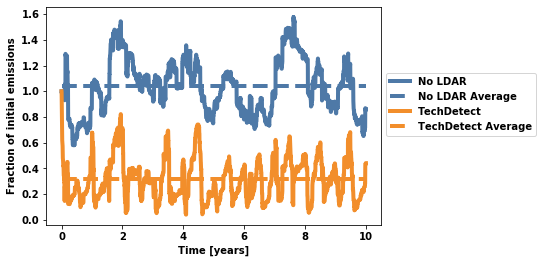

In [3]:
from feast.GeneralClassesFunctions.plotting_functions import time_series
# The next line loads results from the most recently completed simulation.
realn = len(os.listdir('Results')) - 1
time_series('Results/realization' + str(realn) + '.p', line_width=4)

# Customizing a simulation
FEAST simulations use a hierarchy of objects to define parameters. For example, a *gas_field* object contains a set of *sites* which in turn contain multiple *components*. In order to define a custom gas field, parameters from each level can be specified. An example is shown below.

## Component definitions

In [4]:
from feast.GeneralClassesFunctions.simulation_classes import Component
# Generates reparable fugitive emissions
comp_fug = Component(
    name='Fugitive emitters', # A name for referencing in results
    emission_data_path='production_emissions.p', # A path to the data file used to define the emission size distribution 
    emission_per_comp=0.00231,  # The fraction of components that will be leaking at the beginning of the simulation 
    emission_production_rate = 5.4 / 650 / 365 # The rate at which new emissions will be created (#/component/day)
)

# Generates miscelaneous emissions that cannot be repaired
misc_vent = Component(
    name='misc vents',  # A name for referencing in results
    emission_data_path='production_emissions.p',  # A path to the data file used to define the emission size distribution 
    emission_per_comp=0.02, # The fraction of components that will be emitting at the beginning of the simulation 
    emission_production_rate=5.4 / 650 / 365,  # The rate at which new emissions will be created (#/component/day)
    base_reparable=False, # Specifies that these emissions cannot be repaired (defaults to True)
)

## Site definition
A site definition defines the number of various component types included in a site.

In [5]:
basicpad = feast.GeneralClassesFunctions.simulation_classes.Site(
    name='basic pad',
    comp_dict={
        'Fugitive': {'number': 600, 'parameters': comp_fug},
        'misc vent': {'number': 50, 'parameters': misc_vent}
    }
)

# Time definition
The duration and time resolution of the simulation is defined in a time object.

In [6]:
timeobj = feast.GeneralClassesFunctions.simulation_classes.Time(
    delta_t=1 / 24, # Time resolution in days
    end_time=3 * 365 # Simulation duration in days
)

## Gas field definitions
A gas field is defined by the sites that it contains and the time specifications for the simulation.
The sites should be grouped into a dict as shown below.

In [7]:
site_dict = {
    'basic pad': {'number': 100, 'parameters': basicpad}
}
gas_field = feast.GeneralClassesFunctions.simulation_classes.GasField(
    sites=site_dict,
    time=timeobj
)

# LDAR program definitions
LDAR programs have many parameters that can be customized. A few essential parameters are demonstrated below.

In [8]:
tech_dict = {'Null': feast.DetectionModules.null.Null(time=timeobj, gas_field=gas_field)}

# The TechDetect class of LDAR programs effectively simulates any survey based program 
# that detects leaks at the component level. The parameters defined below give a
# reasonable approximation of an ogi survey based LDAR program.

ogi = {'survey_interval': 180, # time between surveys (days)
       'mu': 0.0018, # emission flux with a 50% probability of detection (g/s)
       'lam': 2.23, # width parameter in the probability of detection curve
       'survey_speed': 400 # survey speed (components per hour)
}

tech_dict['ogi'] = feast.DetectionModules.tech_detect.TechDetect(
            timeobj, gas_field,
            **ogi
)

# The TieredDetect class of LDAR programs effectively simulates survey based programs
# that detect leaks at the site level and require a secondary survey at high emitting
# sites to identify leaking components. The parameters defined below give a reasonable
# approximation of a plane based site level survey with a secondary ogi survey at
# high emitting sites.

plane = {
    'survey_interval': 180, 'mu': 0.474,
    'lam': 3.88, 'sites_per_day': 222,
    'lam2': 2.23, 'mu2': 0.002,
    'secondary_comps_hr': 400
}

tech_dict['plane'] = feast.DetectionModules.tiered_detect.TieredDetect(
            timeobj, gas_field,
            **plane
)

In [9]:
feast.field_simulation.field_simulation(
        time=timeobj, gas_field=gas_field,
        tech_dict=tech_dict, display_status=True
)

The evaluation is 0% complete
The evaluation is 10% complete
The evaluation is 20% complete
The evaluation is 30% complete
The evaluation is 40% complete
The evaluation is 50% complete
The evaluation is 60% complete
The evaluation is 70% complete
The evaluation is 80% complete
The evaluation is 90% complete
The evaluation is 100% complete


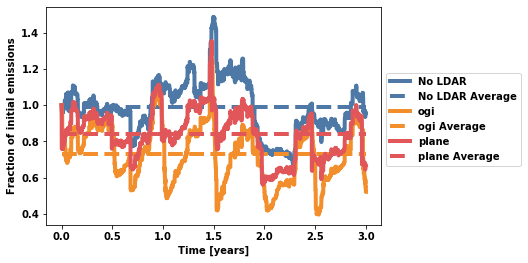

In [10]:
from feast.GeneralClassesFunctions.plotting_functions import time_series
# The next line loads results from the most recently completed simulation.
realn = len(os.listdir('Results')) - 1
time_series('Results/realization' + str(realn) + '.p', line_width=4)

## Using a custom run script

In [11]:
exec(open('Example-RunScript.py').read())

Iteration number: 0
Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29


In [12]:
_, emissions, costs, techs = feast.GeneralClassesFunctions.results_analysis_functions.results_analysis('ExampleRunScriptResults')
with open('ExampleRunScriptResults/realization20.p', 'rb') as f:
    re = pickle.load(f)

(3, 30)


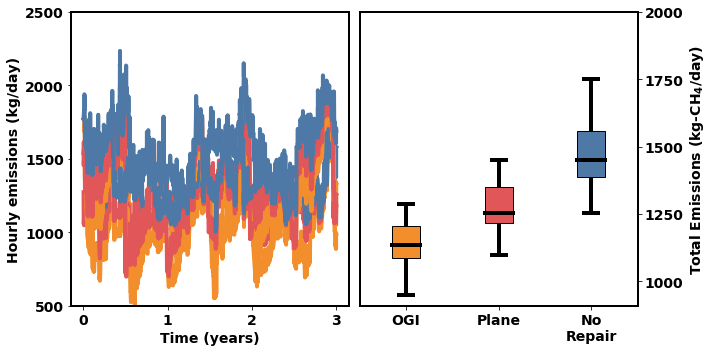

In [13]:
COLORS = np.array([
    [78, 121, 167],
    [242, 142,  43],
    [225,  87,  89],
    [118, 183, 178],
    [89, 161,  79],
    [237, 201, 72],
    [176, 122, 161],
    [255, 157, 167],
    [156, 117,  95],
    [186, 176, 172]
]) / 255
conv_arr = np.ones(24) / 24
t = np.linspace(re.time.delta_t * len(conv_arr) / 2, 
                re.time.end_time - re.time.delta_t * len(conv_arr) / 2, 
                re.time.n_timesteps - len(conv_arr) + 1) / 365
tech_color = [1, 2, 0]
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(10, 5))
handles = []
for ind in range(2):
    for techind in range(emissions.shape[0]):
        a0.plot(t, np.convolve(emissions[techind, :, ind] * 3600 * 24 / 1000, conv_arr, mode='valid'), 
                color=COLORS[tech_color[techind]])
    ind += 1
a0.set_xlabel('Time (years)', fontweight='bold')
a0.set_ylabel('Hourly emissions (kg/day)', fontweight='bold')
a0.set_xticks([0, 1, 2, 3])
a0.set_yticks([500, 1000, 1500, 2000, 2500])
a0.set_ylim([500, 2500])
custom_labels = ['OGI', 'Plane', 'No\nRepair']
emtots = np.sum(emissions, axis=1) * 3600 / 365 / 3 / 1000 # kg/day
print(emtots.shape)
boxplot = a1.boxplot(np.transpose(emtots), labels=custom_labels, patch_artist=True)
ind = 0
for bx in boxplot['boxes']:
    handles.append(bx)
    bx.set(facecolor=COLORS[tech_color[ind]])
    ind += 1
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(boxplot[element], color='k', linewidth=2)
a1 = plt.gca()
a1.set_yticks([1000, 1250, 1500, 1750, 2000])
a1.yaxis.set_label_position("right")
a1.yaxis.tick_right() 
plt.ylabel('Total Emissions (kg-CH$_4$/day)', fontweight='bold')
feast.GeneralClassesFunctions.plotting_functions.plot_fixer(fsize=14)

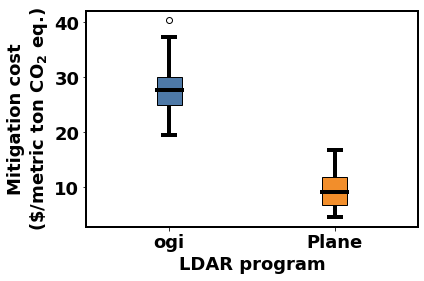

In [4]:
feast.GeneralClassesFunctions.plotting_functions.abatement_cost_plotter('ExampleRunScriptResults')